In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))

['train.csv', 'gender_submission.csv', 'test.csv']


In [2]:
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split,RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.feature_selection import RFECV

import lightgbm as lgb

import re

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [4]:
train.describe()
# Missing Value in train['Age']

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [7]:
data = train.append(test)
data.reset_index(inplace = True, drop = True)
data

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


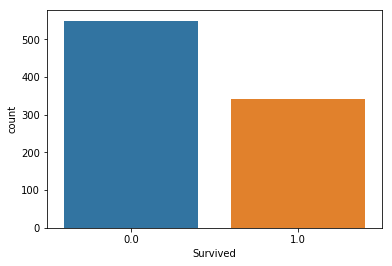

In [8]:
sns.countplot(data['Survived'])
#The data is balanced

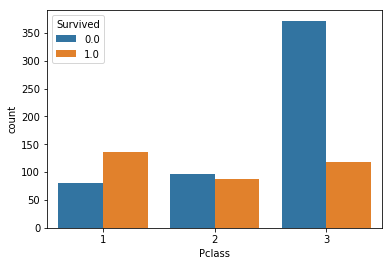

In [9]:
sns.countplot(data['Pclass'],hue = data['Survived'])

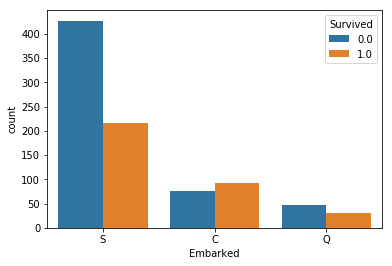

In [10]:
sns.countplot(data['Embarked'],hue = data['Survived'])

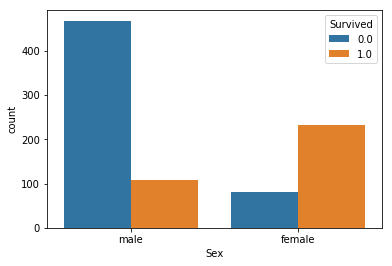

In [11]:
sns.countplot(data['Sex'],hue = data['Survived'])

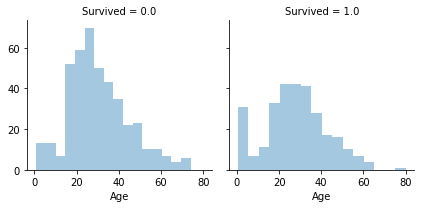

In [12]:
g = sns.FacetGrid(data, col = 'Survived')
g.map(sns.distplot, 'Age', kde= False)
#younger people were apt to survive

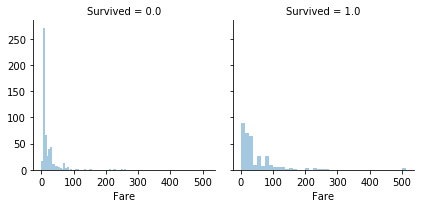

In [13]:
g = sns.FacetGrid(data, col = 'Survived')
g.map(sns.distplot, 'Fare', kde= False)
#higher mortablity rate for lower priced passengers

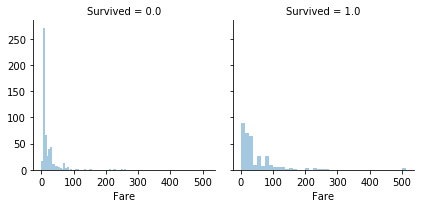

In [14]:
g = sns.FacetGrid(data, col = 'Survived')
g.map(sns.distplot, 'Fare', kde= False)

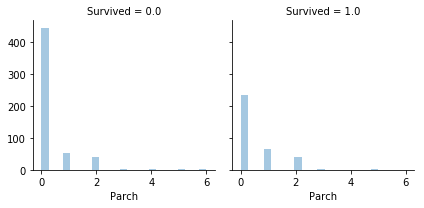

In [15]:
g = sns.FacetGrid(data, col = 'Survived')
g.map(sns.distplot, 'Parch', kde= False)
#People who didn't bring their parents or children tend to have lower survival rate

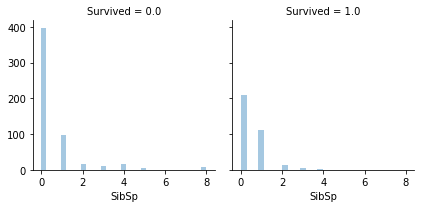

In [16]:
g = sns.FacetGrid(data, col = 'Survived')
g.map(sns.distplot, 'SibSp', kde= False)
#People who didn't bring their brothers or sisters tend to have lower survival rate
#This feature can be combined with 'Parch', called family_size

In [17]:
data['Family_size'] = data['SibSp'] + data['Parch']+1

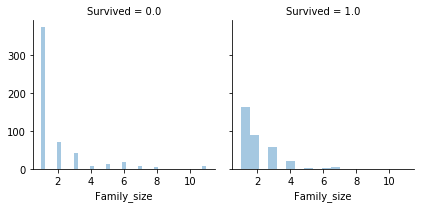

In [18]:
g = sns.FacetGrid(data, col = 'Survived')
g.map(sns.distplot, 'Family_size', kde= False)

#It can be more obvious that the bigger the families are the high survival rate they have

In [19]:
data['Name'].str.split(', ',expand = True)[1].str.split('.', expand = True)[0].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [20]:
#Combine titles according to the social status and genders

Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty",
    "Dona" : "Royalty"
}


# we extract the title from each name
data['Title_status'] = data['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
data['Title_status'] = data['Title_status'].map(Title_Dictionary)

data['Title_status'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Royalty', 'Officer'], dtype=object)

In [21]:
#one-hot encoding of 'Title_status'

titles_dummies = pd.get_dummies(data['Title_status'], prefix='Title')
data = pd.concat([data, titles_dummies], axis=1)
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_size,Title_status,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,Mr,0,0,1,0,0,0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Mrs,0,0,0,1,0,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,Miss,0,1,0,0,0,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Mrs,0,0,0,1,0,0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,Mr,0,0,1,0,0,0


In [22]:
data['Ticket'].head(10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

In [23]:
data['Ticket_alpha'] = data['Ticket'].apply(lambda x:x.replace(".","").replace("/", "").strip().split(" ")[0] if not x.isdigit() else 'X')
len(data['Ticket_alpha'].unique())

37

In [24]:
#Hard to engineer this feature
data['Ticket_number']=data['Ticket'].apply(lambda x:re.sub('[^0-9]','', x))
len(data['Ticket_number'].unique())

924

In [25]:
#One-hot encoding the 'Ticket_alpha'

ticket_dummies = pd.get_dummies(data['Ticket_alpha'], prefix='Ticket')
data = pd.concat([data, ticket_dummies], axis=1)
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,0,0,0,0,0,0,0,0,0,0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,0,0,0,0,0,0,0,0,0,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,0,0,0,0,1,0,0,0,0,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,0,0,0,0,0,0,0,0,0,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,0,0,0,0,0,0,0,0,0,1


In [26]:
#Dealing with missing value
data['Embarked'] = data['Embarked'].fillna('S')
data['Fare'] = data['Fare'].fillna(data['Fare'].median())
data['Cabin'] = data['Cabin'].apply(lambda x:str(x)[0] if not pd.isnull(x) else 'NoCabin')
data['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [27]:
#One-hot encoding the 'Embarked'

embarked_dummies = pd.get_dummies(data['Embarked'], prefix='Embarked')
data = pd.concat([data, embarked_dummies], axis=1)

data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X,Embarked_C,Embarked_Q,Embarked_S
0,22.0,NoCabin,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,0,0,0,0,0,0,0,0,0,1
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,0,0,0,0,0,0,0,1,0,0
2,26.0,NoCabin,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,0,0,0,0,0,0,1,0,0,1
4,35.0,NoCabin,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,0,0,0,0,0,0,1,0,0,1


In [28]:
#One-hot encoding the 'Cabin'

cabin_dummies = pd.get_dummies(data['Cabin'], prefix='Cabin')    
data = pd.concat([data, cabin_dummies], axis=1)

data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NoCabin,Cabin_T
0,22.0,NoCabin,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,1,0,0,0,0,0,0,0,1,0
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,0,0,0,1,0,0,0,0,0,0
2,26.0,NoCabin,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,1,0,0,0,0,0,0,0,1,0
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,1,0,0,1,0,0,0,0,0,0
4,35.0,NoCabin,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,1,0,0,0,0,0,0,0,1,0


In [29]:
#One-hot encoding the 'Cabin'

pclass_dummies = pd.get_dummies(data['Pclass'], prefix="Pclass")
data = pd.concat([data, pclass_dummies],axis=1)

data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NoCabin,Cabin_T,Pclass_1,Pclass_2,Pclass_3
0,22.0,NoCabin,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,0,0,0,0,0,1,0,0,0,1
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,1,0,0,0,0,0,0,1,0,0
2,26.0,NoCabin,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,0,0,0,0,0,1,0,0,0,1
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,1,0,0,0,0,0,0,1,0,0
4,35.0,NoCabin,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,0,0,0,0,0,1,0,0,0,1


Fare        
Survived    0.0     1.0
Pclass                 
1         44.75  77.958
2         13.00  21.000
3          8.05   8.517

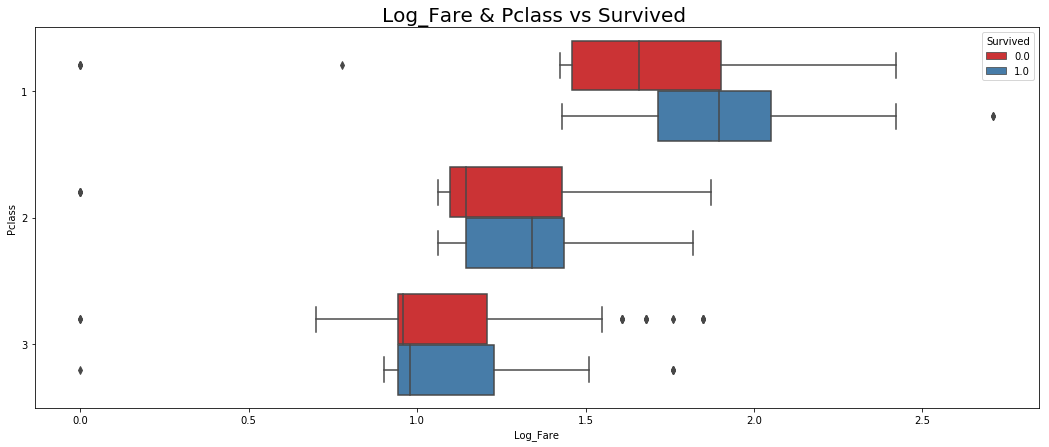

In [30]:
fig, ax = plt.subplots( figsize = (18,7) )
data['Log_Fare'] = (data['Fare']+1).map(lambda x : np.log10(x) if x > 0 else 0)
sns.boxplot(y='Pclass', x='Log_Fare',hue='Survived',data=data, orient='h'
                ,ax=ax,palette="Set1")
ax.set_title('Log_Fare & Pclass vs Survived ',fontsize = 20)
pd.pivot_table(data,values = ['Fare'], index = ['Pclass'], columns= ['Survived'] ,aggfunc = 'median').round(3)

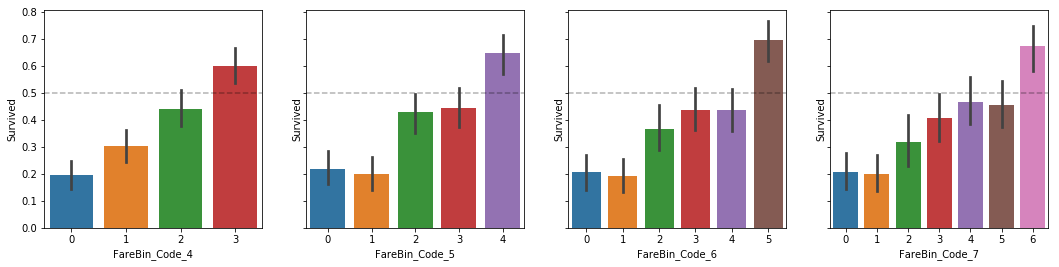

In [31]:
# Making Bins
data['FareBin_4'] = pd.qcut(data['Fare'], 4)
data['FareBin_5'] = pd.qcut(data['Fare'], 5)
data['FareBin_6'] = pd.qcut(data['Fare'], 6)
data['FareBin_7'] = pd.qcut(data['Fare'], 7)

label = LabelEncoder()
data['FareBin_Code_4'] = label.fit_transform(data['FareBin_4'])
data['FareBin_Code_5'] = label.fit_transform(data['FareBin_5'])
data['FareBin_Code_6'] = label.fit_transform(data['FareBin_6'])
data['FareBin_Code_7'] = label.fit_transform(data['FareBin_7'])

# plots
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4,sharey=True)
fig.set_figwidth(18)
for axi in [ax1, ax2, ax3, ax4]:
    axi.axhline(0.5,linestyle='dashed', c='black',alpha = .3)
g1 = sns.factorplot(x='FareBin_Code_4', y="Survived", data=data,kind='bar',ax=ax1)
g2 = sns.factorplot(x='FareBin_Code_5', y="Survived", data=data,kind='bar',ax=ax2)
g3 = sns.factorplot(x='FareBin_Code_6', y="Survived", data=data,kind='bar',ax=ax3)
g4 = sns.factorplot(x='FareBin_Code_7', y="Survived", data=data,kind='bar',ax=ax4)
# close FacetGrid object
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)
plt.close(g4.fig)

In [32]:
data['Sex'] = data['Sex'].map({'female' : 1, 'male' : 0}).astype('int')
# splits again beacuse we just engineered new feature
df_train = data[:len(train)]
df_test = data[len(train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']
# show columns
X.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Ticket', 'Family_size', 'Title_status', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty',
       'Ticket_alpha', 'Ticket_number', 'Ticket_A', 'Ticket_A4', 'Ticket_A5',
       'Ticket_AQ3', 'Ticket_AQ4', 'Ticket_AS', 'Ticket_C', 'Ticket_CA',
       'Ticket_CASOTON', 'Ticket_FC', 'Ticket_FCC', 'Ticket_Fa', 'Ticket_LINE',
       'Ticket_LP', 'Ticket_PC', 'Ticket_PP', 'Ticket_PPP', 'Ticket_SC',
       'Ticket_SCA3', 'Ticket_SCA4', 'Ticket_SCAH', 'Ticket_SCOW',
       'Ticket_SCPARIS', 'Ticket_SCParis', 'Ticket_SOC', 'Ticket_SOP',
       'Ticket_SOPP', 'Ticket_SOTONO2', 'Ticket_SOTONOQ', 'Ticket_SP',
       'Ticket_STONO', 'Ticket_STONO2', 'Ticket_STONOQ', 'Ticket_SWPP',
       'Ticket_WC', 'Ticket_WEP', 'Ticket_X', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin

In [33]:
Y.isnull().value_counts()

False    891
Name: Survived, dtype: int64

In [34]:
#5 fold got best oob score -> choose this
b4, b5, b6, b7 = ['Sex', 'Pclass','FareBin_Code_4'], ['Sex','Pclass','FareBin_Code_5'],\
['Sex','Pclass','FareBin_Code_6'], ['Sex','Pclass','FareBin_Code_7']
b4_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b4_Model.fit(X[b4], Y)
b5_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b5_Model.fit(X[b5], Y)
b6_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b6_Model.fit(X[b6], Y)
b7_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b7_Model.fit(X[b7], Y)
print('b4 oob score :%.5f' %(b4_Model.oob_score_),)
print('b5 oob score :%.5f '%(b5_Model.oob_score_),)
print('b6 oob score : %.5f' %(b6_Model.oob_score_),)
print('b7 oob score : %.5f' %(b7_Model.oob_score_),)

b4 oob score :0.80584
b5 oob score :0.81033 
b6 oob score : 0.80135
b7 oob score : 0.79798


In [35]:
#one-hot encoding engineered Fare feature
cabin_dummies = pd.get_dummies(data['FareBin_Code_5'], prefix='Fare_group')    
data = pd.concat([data, cabin_dummies], axis=1)

data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,FareBin_7,FareBin_Code_4,FareBin_Code_5,FareBin_Code_6,FareBin_Code_7,Fare_group_0,Fare_group_1,Fare_group_2,Fare_group_3,Fare_group_4
0,22.0,NoCabin,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,...,"(-0.001, 7.75]",0,0,0,0,1,0,0,0,0
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,...,"(59.4, 512.329]",3,4,5,6,0,0,0,0,1
2,26.0,NoCabin,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,...,"(7.75, 8.05]",1,1,1,1,0,1,0,0,0
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,...,"(27.793, 59.4]",3,4,4,5,0,0,0,0,1
4,35.0,NoCabin,S,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,...,"(7.75, 8.05]",1,1,1,1,0,1,0,0,0


In [36]:
df_train['Ticket'].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

In [37]:
duplicate_ticket = []
for tk in data.Ticket.unique():
    tem = data.loc[data.Ticket == tk, 'Fare']
    if tem.count() > 1:
        duplicate_ticket.append(data.loc[data.Ticket == tk,['Name','Ticket','Fare','Cabin','Family_size','Survived']])
duplicate_ticket = pd.concat(duplicate_ticket)
duplicate_ticket.head(40)

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C,2,1.0
1125,"Cumings, Mr. John Bradley",PC 17599,71.2833,C,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E,1,0.0
1037,"Hilliard, Mr. Herbert Henry",17463,51.8625,E,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NoCabin,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NoCabin,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NoCabin,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NoCabin,5,0.0


In [38]:
group_ticket = duplicate_ticket.loc[(duplicate_ticket.Family_size == 1) & (duplicate_ticket.Survived.notnull())].head(7)
family_ticket = duplicate_ticket.loc[(duplicate_ticket.Family_size > 1) & (duplicate_ticket.Survived.notnull())].head(7)

print('people keep the same ticket: %.0f '%len(duplicate_ticket))
print('friends: %.0f '%len(duplicate_ticket[duplicate_ticket.Family_size == 1]))
print('families: %.0f '%len(duplicate_ticket[duplicate_ticket.Family_size > 1]))

people keep the same ticket: 596 
friends: 127 
families: 469 


In [39]:
# the same ticket family or friends
data['Connected_Survival'] = 0.5 # default 
for _, grp in data.groupby('Ticket'):
    if (len(grp) > 1):
        for ind, row in grp.iterrows():
            smax = grp.drop(ind)['Survived'].max()
            smin = grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                data.loc[data['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(duplicate_ticket))
print("people have connected information : %.0f" 
      %(data[data['Connected_Survival']!=0.5].shape[0]))
data.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


In [40]:
pd.set_option("display.max_columns", None)
data

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_size,Title_status,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Ticket_alpha,Ticket_number,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NoCabin,Cabin_T,Pclass_1,Pclass_2,Pclass_3,Log_Fare,FareBin_4,FareBin_5,FareBin_6,FareBin_7,FareBin_Code_4,FareBin_Code_5,FareBin_Code_6,FareBin_Code_7,Fare_group_0,Fare_group_1,Fare_group_2,Fare_group_3,Fare_group_4,Connected_Survival
0,22.0,NoCabin,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,2,Mr,0,0,1,0,0,0,A5,521171,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0.916454,"(-0.001, 7.896]","(-0.001, 7.854]","(-0.001, 7.775]","(-0.001, 7.75]",0,0,0,0,1,0,0,0,0,0.5
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,2,Mrs,0,0,0,1,0,0,PC,17599,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1.859038,"(31.275, 512.329]","(41.579, 512.329]","(53.1, 512.329]","(59.4, 512.329]",3,4,5,6,0,0,0,0,1,0.5
2,26.0,NoCabin,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,1,Miss,0,1,0,0,0,0,STONO2,23101282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0.950608,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]","(7.75, 8.05]",1,1,1,1,0,1,0,0,0,0.5
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,2,Mrs,0,0,0,1,0,0,X,113803,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1.733197,"(31.275, 512.329]","(41.579, 512.329]","(26.0, 53.1]","(27.793, 59.4]",3,4,4,5,0,0,0,0,1,0.0
4,35.0,NoCabin,S,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,1,Mr,0,0,1,0,0,0,X,373450,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0.956649,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]","(7.75, 8.05]",1,1,1,1,0,1,0,0,0,0.5
5,NaN,NoCabin,Q,8.4583,"Moran, Mr. James",0,6,3,0,0,0.0,330877,1,Mr,0,0,1,0,0,0,X,330877,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0.975813,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]","(8.05, 12.875]",1,1,1,2,0,1,0,0,0,0.5
6,54.0,E,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,0,0,0.0,17463,1,Mr,0,0,1,0,0,0,X,17463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1.723148,"(31.275, 512.329]","(41.579, 512.329]","(26.0, 53.1]","(27.793, 59.4]",3,4,4,5,0,0,0,0,1,0.5
7,2.0,NoCabin,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,0,3,0.0,349909,5,Master,1,0,0,0,0,0,X,349909,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1.343901,"(14.454, 31.275]","(10.5, 21.558]","(14.454, 26.0]","(19.258, 27.793]",2,2,3,4,0,0,1,0,0,0.0
8,27.0,NoCabin,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,1,0,1.0,347742,3,Mrs,0,0,0,1,0,0,X,347742,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1.083979,"(7.896, 14.454]","(10.5, 21.558]","(8.662, 14.454]","(8.05, 12.875]",1,2,2,2,0,0,1,0,0,1.0
9,14.0,NoCabin,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,1,1,1.0,237736,2,Mrs,0,0,0,1,0,0,X,237736,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1.492352,"(14.45

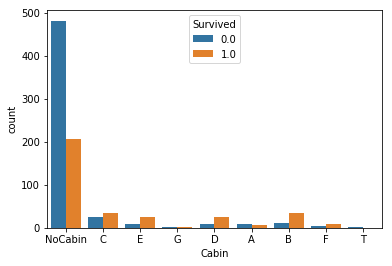

In [41]:
sns.countplot(data['Cabin'], hue = data['Survived'])
#People in th cabin had high chance to survived

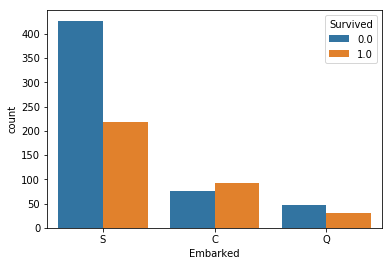

In [42]:
sns.countplot(data['Embarked'], hue = data['Survived'])
#People from S port got high survival rate

In [43]:
data['Sex'] = data['Sex'].astype('category').cat.codes

In [44]:
data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Family_size',
       'Title_status', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Ticket_alpha', 'Ticket_number',
       'Ticket_A', 'Ticket_A4', 'Ticket_A5', 'Ticket_AQ3', 'Ticket_AQ4',
       'Ticket_AS', 'Ticket_C', 'Ticket_CA', 'Ticket_CASOTON', 'Ticket_FC',
       'Ticket_FCC', 'Ticket_Fa', 'Ticket_LINE', 'Ticket_LP', 'Ticket_PC',
       'Ticket_PP', 'Ticket_PPP', 'Ticket_SC', 'Ticket_SCA3', 'Ticket_SCA4',
       'Ticket_SCAH', 'Ticket_SCOW', 'Ticket_SCPARIS', 'Ticket_SCParis',
       'Ticket_SOC', 'Ticket_SOP', 'Ticket_SOPP', 'Ticket_SOTONO2',
       'Ticket_SOTONOQ', 'Ticket_SP', 'Ticket_STONO', 'Ticket_STONO2',
       'Ticket_STONOQ', 'Ticket_SWPP', 'Ticket_WC', 'Ticket_WEP', 'Ticket_X',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Cabin_A', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', '

In [45]:
#cleaning features
data.drop(['Cabin', 'Embarked', 'Fare', 'Name', 'Parch','Pclass','SibSp','Ticket','Ticket_alpha', 'Ticket_number',
          'Log_Fare', 'FareBin_4', 'FareBin_5','FareBin_6', 'FareBin_7', 'FareBin_Code_4','FareBin_Code_5','FareBin_Code_6', 'FareBin_Code_7','Title_status']
          ,axis =1 ,inplace = True)

In [46]:
data.head()

,Age,PassengerId,Sex,Survived,Family_size,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NoCabin,Cabin_T,Pclass_1,Pclass_2,Pclass_3,Fare_group_0,Fare_group_1,Fare_group_2,Fare_group_3,Fare_group_4,Connected_Survival
0,22.0,1,0,0.0,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.5
1,38.0,2,1,1.0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.5
2,26.0,3,1,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.5
3,35.0,4,1,1.0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.0
4,35.0,5,0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.5


In [47]:
data['Age'].describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.2s finished


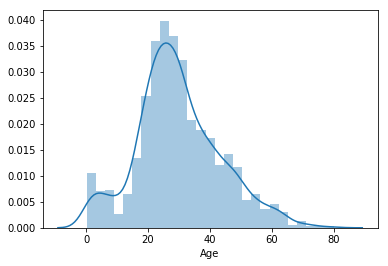

In [48]:
#About 20% of missing values in age column
dataAgeNull = data[data["Age"].isnull()]
dataAgeNotNull = data[data["Age"].notnull()]

X = dataAgeNotNull.drop(['Survived','Age'], axis = 1, inplace = False)
y = dataAgeNotNull["Age"]
rf_age = RandomForestRegressor(n_estimators=2000,random_state=42,verbose = 1)
rf_age.fit(X, y)


dataAgeNull_2 = dataAgeNull.drop(['Survived','Age'], axis = 1, inplace = False)
ageNullValues = rf_age.predict(dataAgeNull_2)

dataAgeNull.loc[:,"Age"] = ageNullValues
data = dataAgeNull.append(dataAgeNotNull)
data.reset_index(inplace=True, drop=True)
sns.distplot(data['Age'])


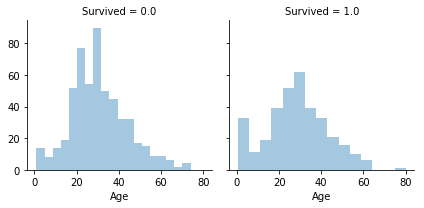

In [49]:
#people with smaller age has higher survivial rate
g = sns.FacetGrid(data, col='Survived')
g.map(sns.distplot, 'Age', kde=False)

In [50]:
#below certain age, the survivial rate is obviouly higher
data['Age'] = data['Age'].apply(lambda x : 1 if x<=16 else 0) 
data
# data['AgeBin_6'] = pd.qcut(data['Age'], 6)
# label = LabelEncoder()
# data['Age_Code_6'] = label.fit_transform(data['AgeBin_6'])

# pclass_dummies = pd.get_dummies(data['Age_Code_6'], prefix="Age")
# data = pd.concat([data, pclass_dummies],axis=1)
# data

,Age,PassengerId,Sex,Survived,Family_size,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NoCabin,Cabin_T,Pclass_1,Pclass_2,Pclass_3,Fare_group_0,Fare_group_1,Fare_group_2,Fare_group_3,Fare_group_4,Connected_Survival
0,0,6,0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.5
1,0,18,0,1.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0.5
2,0,20,1,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.5
3,0,27,0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.5
4,0,29,1,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.5
5,0,30,0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.5
6,0,32,1,1.0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1.0
7,1,33,1,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.5
8,0,37,0,1.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.5
9,0,43,0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.5


In [51]:
data_train = data[pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])
data_test = data[~pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])

In [52]:
data_train.head()

,Age,PassengerId,Sex,Survived,Family_size,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NoCabin,Cabin_T,Pclass_1,Pclass_2,Pclass_3,Fare_group_0,Fare_group_1,Fare_group_2,Fare_group_3,Fare_group_4,Connected_Survival
263,0,1,0,0.0,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.5
264,0,2,1,1.0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.5
265,0,3,1,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.5
266,0,4,1,1.0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.0
267,0,5,0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.5


In [53]:
data_test.head()

,Age,PassengerId,Sex,Survived,Family_size,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NoCabin,Cabin_T,Pclass_1,Pclass_2,Pclass_3,Fare_group_0,Fare_group_1,Fare_group_2,Fare_group_3,Fare_group_4,Connected_Survival
977,0,892,0,NaN,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.5
978,0,893,1,NaN,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.5
979,0,894,0,NaN,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0.5
980,0,895,0,NaN,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.5
981,0,896,1,NaN,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1.0


In [54]:
data_train.columns

Index(['Age', 'PassengerId', 'Sex', 'Survived', 'Family_size', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty',
       'Ticket_A', 'Ticket_A4', 'Ticket_A5', 'Ticket_AQ3', 'Ticket_AQ4',
       'Ticket_AS', 'Ticket_C', 'Ticket_CA', 'Ticket_CASOTON', 'Ticket_FC',
       'Ticket_FCC', 'Ticket_Fa', 'Ticket_LINE', 'Ticket_LP', 'Ticket_PC',
       'Ticket_PP', 'Ticket_PPP', 'Ticket_SC', 'Ticket_SCA3', 'Ticket_SCA4',
       'Ticket_SCAH', 'Ticket_SCOW', 'Ticket_SCPARIS', 'Ticket_SCParis',
       'Ticket_SOC', 'Ticket_SOP', 'Ticket_SOPP', 'Ticket_SOTONO2',
       'Ticket_SOTONOQ', 'Ticket_SP', 'Ticket_STONO', 'Ticket_STONO2',
       'Ticket_STONOQ', 'Ticket_SWPP', 'Ticket_WC', 'Ticket_WEP', 'Ticket_X',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Cabin_A', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_NoCabin',
       'Cabin_T', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Fare_group_0',
       'Fare_group_1', 'Fare_g

In [55]:
X = data_train.drop(['Survived','PassengerId'], axis = 1)
y = data_train['Survived']
X_test = data_test.drop(['Survived','PassengerId'], axis = 1)
random_state = 42
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = random_state)

In [56]:
X.head(10)

,Age,Sex,Family_size,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NoCabin,Cabin_T,Pclass_1,Pclass_2,Pclass_3,Fare_group_0,Fare_group_1,Fare_group_2,Fare_group_3,Fare_group_4,Connected_Survival
263,0,0,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.5
264,0,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.5
265,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.5
266,0,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.0
267,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.5
0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.5
268,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0.5
269,1,0,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0.0
270,0,1,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1.0
271,1,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0.0


In [57]:
X_test.head()

,Age,Sex,Family_size,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NoCabin,Cabin_T,Pclass_1,Pclass_2,Pclass_3,Fare_group_0,Fare_group_1,Fare_group_2,Fare_group_3,Fare_group_4,Connected_Survival
977,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.5
978,0,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.5
979,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0.5
980,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.5
981,0,1,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1.0


In [58]:
%%time
lgbm_clf_test = lgb.LGBMClassifier()
lgbm_clf_test.fit(X, y)
scores=cross_val_score(lgbm_clf_test, X, y, scoring='accuracy', cv=5)
print('{:.5f}'.format(np.mean(scores)))

0.83281
CPU times: user 3.5 s, sys: 584 ms, total: 4.08 s
Wall time: 1.06 s


In [59]:
features = pd.DataFrame()
features['feature'] = X.columns
features['importance_lgbm_test'] = lgbm_clf_test.feature_importances_
features.head()

,feature,importance_lgbm_test
0,Age,61
1,Sex,134
2,Family_size,341
3,Title_Master,51
4,Title_Miss,31


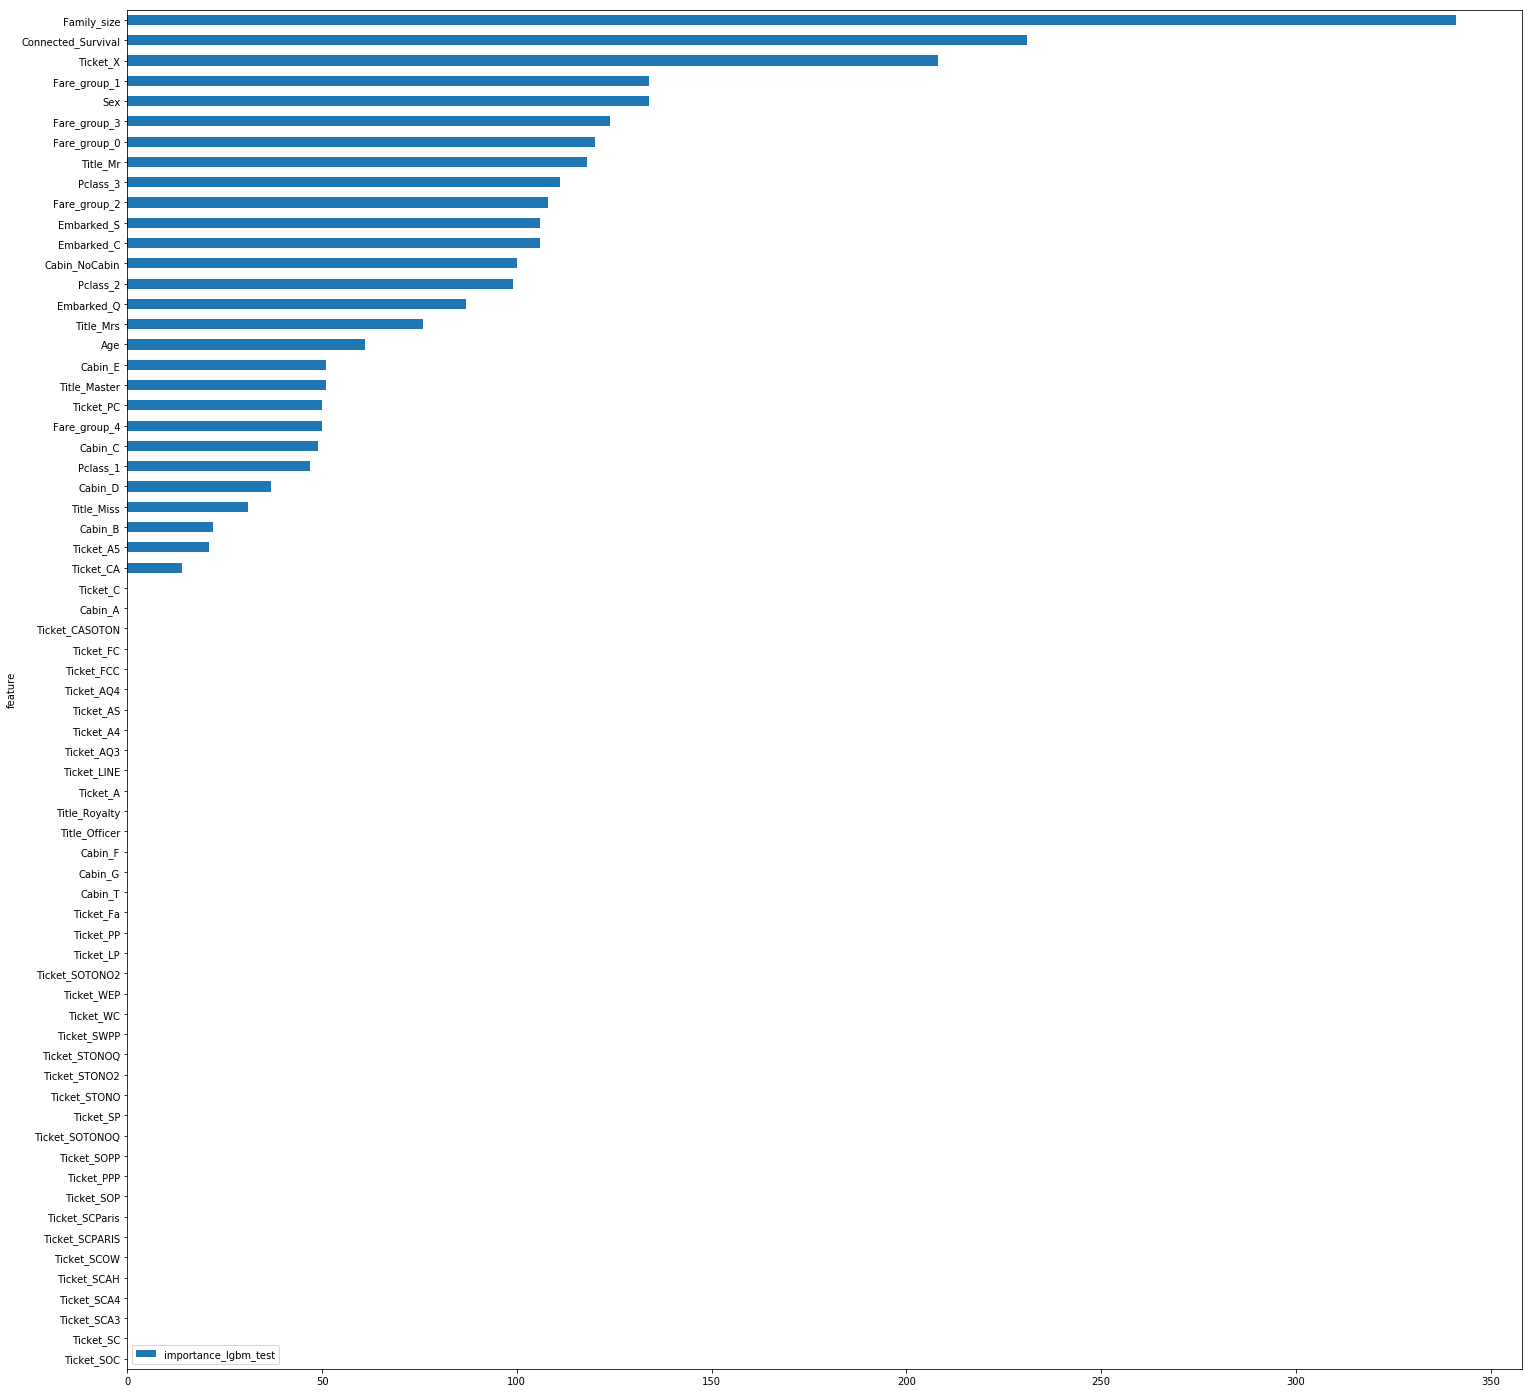

In [60]:
features.sort_values(by=['importance_lgbm_test'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(25, 25))

In [61]:
#feature selection
model = SelectFromModel(lgbm_clf_test, prefit=True)
X_reduced = model.transform(X)
print (X_reduced.shape)

(891, 23)


In [62]:
test_reduced = model.transform(X_test)
print(test_reduced.shape)

(418, 23)


In [63]:
X_train_reduced, X_valid_reduced, y_train_reduced, y_valid_reduced = train_test_split(X_reduced, y, test_size = 0.2, random_state = random_state)

In [64]:
%%time
fit_params = {"early_stopping_rounds" : 50, 
             "eval_metric" : 'auc', 
             "eval_set" : [(X_valid_reduced,y_valid_reduced)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95],
              'bagging_fraction': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95],
              'bagging_freq': [1, 2, 4, 5, 6, 8],
              'num_leaves': [5, 10, 15, 20, 25, 30, 35, 40, 50, 60], 
              'min_child_samples': sp_randint(5,40), 
              'min_sum_hessian_in_leaf':[1e-5, 1e-4,1e-3,1e-2,1e-1],
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'max_depth': [-1],
              'reg_alpha': [0, 0.1, 0.4, 0.5, 0.6],
              'reg_lambda': [0, 0.1, 1, 5, 10, 15, 35, 40],
              'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
              'min_gain_to_split':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

#number of combinations
n_iter = 1000

#intializing lgbm and lunching the search
lgbm_clf = lgb.LGBMClassifier(boosting ='rf', random_state=random_state, silent=True, metric='None', n_jobs=-1)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X_reduced, y, **fit_params)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

opt_parameters =  grid_search.best_params_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score reached: 0.8496071829405163 with params: {'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 35, 'min_child_weight': 0.1, 'min_gain_to_split': 0.8, 'min_sum_hessian_in_leaf': 0.001, 'n_estimators': 400, 'num_leaves': 20, 'reg_alpha': 0.1, 'reg_lambda': 0} 
CPU times: user 16min 39s, sys: 2min 6s, total: 18min 46s
Wall time: 4min 51s


[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:  4.8min finished


In [65]:
print(opt_parameters)

{'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 35, 'min_child_weight': 0.1, 'min_gain_to_split': 0.8, 'min_sum_hessian_in_leaf': 0.001, 'n_estimators': 400, 'num_leaves': 20, 'reg_alpha': 0.1, 'reg_lambda': 0}


In [66]:
%%time
lgbm_clf_tuned = lgb.LGBMClassifier(**opt_parameters)
lgbm_clf_tuned.fit(X_reduced, y)
scores_lgbm_tuned=cross_val_score(lgbm_clf_tuned, X_reduced, y, scoring='accuracy', cv=5)
print('{:.5f}'.format(np.mean(scores_lgbm_tuned)))

0.84176
CPU times: user 2.18 s, sys: 296 ms, total: 2.48 s
Wall time: 645 ms


In [67]:
%%time
import xgboost as xgb

xgb_clf_test = xgb.XGBClassifier()
xgb_clf_test.fit(X, y)
scores=cross_val_score(xgb_clf_test, X, y, scoring='accuracy', cv=5)
print('{:.5f}'.format(np.mean(scores)))

0.83054
CPU times: user 1.07 s, sys: 68 ms, total: 1.14 s
Wall time: 1.24 s


In [68]:
%%time
import xgboost as xgb

fit_params2 = {"early_stopping_rounds" : 50, 
             "eval_metric" : 'auc', 
             "eval_set" : [(X_valid_reduced, y_valid_reduced)],
             'verbose': 0}

param_test2 = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
               'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
              'n_estimators' : [200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95,1],
              'bagging_fraction': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95,1],
              'bagging_freq': [2, 4, 5, 6, 8],
              'min_child_samples': sp_randint(10, 70), 
              'min_sum_hessian_in_leaf':[1e-5, 1e-4,1e-3,1e-2,1e-1],
              'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'reg_alpha': [0, 0.1, 0.4, 0.5, 0.6],
              'reg_lambda': [0, 0.1, 1, 5, 10, 15, 35, 40],
              'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
              'min_gain_to_split':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

#number of combinations
n_iter = 800

#intializing lgbm and lunching the search
xgb_clf = xgb.XGBClassifier(random_state=random_state, silent=True, metric='None', n_jobs=-1)
grid_search = RandomizedSearchCV(
    estimator=xgb_clf, param_distributions=param_test2, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X_reduced, y, **fit_params2)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

opt_parameters2 =  grid_search.best_params_


Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score reached: 0.8451178451178452 with params: {'bagging_fraction': 0.5, 'bagging_freq': 2, 'feature_fraction': 0.8, 'gamma': 0.6, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_samples': 39, 'min_child_weight': 4, 'min_gain_to_split': 0.5, 'min_sum_hessian_in_leaf': 0.1, 'n_estimators': 600, 'reg_alpha': 0.4, 'reg_lambda': 10} 
CPU times: user 15min 20s, sys: 1min 6s, total: 16min 26s
Wall time: 16min 26s


[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed: 16.4min finished


In [69]:
print(opt_parameters2)

{'bagging_fraction': 0.5, 'bagging_freq': 2, 'feature_fraction': 0.8, 'gamma': 0.6, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_samples': 39, 'min_child_weight': 4, 'min_gain_to_split': 0.5, 'min_sum_hessian_in_leaf': 0.1, 'n_estimators': 600, 'reg_alpha': 0.4, 'reg_lambda': 10}


In [70]:
%%time
xgb_clf_tuned= xgb.XGBClassifier(**opt_parameters2)
xgb_clf_tuned.fit(X_reduced, y)
scoresXGB=cross_val_score(xgb_clf_tuned, X_reduced, y, scoring='accuracy', cv=5)
print('{:.5f}'.format(np.mean(scoresXGB)))
scoresXGB

0.84065
CPU times: user 5.86 s, sys: 476 ms, total: 6.33 s
Wall time: 6.33 s


array([0.83240223, 0.84357542, 0.86516854, 0.80898876, 0.85310734])

In [71]:
%%time
RF=RandomForestClassifier(random_state=1)
RF.fit(X, y)
scores_RF1=cross_val_score(RF,X,y,scoring='accuracy',cv=5)
print('{:.5f}'.format(np.mean(scores_RF1)))

0.81937
CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 129 ms


In [72]:
# %%time

param_test3 = {'bootstrap': [True],
               'max_features': ['sqrt', 'auto', 'log2'],
               'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
               'max_features': [2, 3, 4, 5, 6, 7, 10],
               'min_samples_leaf': [1, 3, 4, 5, 7, 10],
               'min_samples_split': [0.1 ,0.3, 0.5, 0.7, 0.9],
               'n_estimators': [200, 300, 400, 500, 600, 800, 1000, 1500, 2000]}

#number of combinations
n_iter = 800

#intializing lgbm and lunching the search
RF_clf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
grid_search = RandomizedSearchCV(estimator=RF_clf, 
                                 param_distributions=param_test3,
                                 n_iter=n_iter,
                                 scoring='accuracy',
                                 cv=5,
                                 refit=True,
                                 random_state=random_state,
                                 verbose=True)

grid_search.fit(X_reduced, y)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

opt_parameters3 =  grid_search.best_params_

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed: 74.6min finished


Best score reached: 0.8451178451178452 with params: {'n_estimators': 1000, 'min_samples_split': 0.1, 'min_samples_leaf': 7, 'max_features': 10, 'max_depth': 6, 'bootstrap': True} 


In [73]:
%%time
RF_clf_tuned = RandomForestClassifier(**opt_parameters3)
RF_clf_tuned.fit(X_reduced, y)
scoresRF=cross_val_score(RF_clf_tuned, X_reduced, y, scoring='accuracy', cv=5)
print('{:.5f}'.format(np.mean(scoresRF)))

0.84286
CPU times: user 6.63 s, sys: 0 ns, total: 6.63 s
Wall time: 6.63 s


In [74]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
svc=make_pipeline(StandardScaler(),SVC(random_state=1, probability=True))
r=[0.0001,0.001,0.1,1,10,50,100]
PSVM=[{'svc__C':r, 'svc__kernel':['linear']},
      {'svc__C':r, 'svc__gamma':r, 'svc__kernel':['rbf']}]
GSSVM=GridSearchCV(estimator=svc, param_grid=PSVM, scoring='accuracy', cv=5)
GSSVM.fit(X_reduced, y)
scores_svm=cross_val_score(GSSVM, X_reduced.astype(float), y, scoring='accuracy', cv=5)

print('{:.5f}'.format(np.mean(scores_svm)))

0.83501


In [75]:
from sklearn.linear_model import LogisticRegression
lo_clf = LogisticRegression(random_state=43, solver='lbfgs',multi_class='multinomial')
lo_clf.fit(X_reduced, y)
scores_lo=cross_val_score(lo_clf, X_reduced.astype(float), y, scoring='accuracy', cv=5)
print('{:.5f}'.format(np.mean(scores_lo)))

0.83395


In [76]:
submit1 = pd.read_csv('../input/gender_submission.csv')
y_test1 = lgbm_clf_tuned.predict(test_reduced )
submit1['Survived'] = y_test1
submit1['Survived'] = submit1['Survived'].astype(int)
submit1.to_csv('submit_lgbm_tuned_reduced_training.csv', index= False)
submit1.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [77]:
submit2 = pd.read_csv('../input/gender_submission.csv')
y_test2 = xgb_clf_tuned.predict(test_reduced )
submit2['Survived'] = y_test2 
submit2['Survived'] = submit2['Survived'].astype(int)
submit2.to_csv('submit_xgb_tuned_reduced_training.csv', index= False)
submit2

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [78]:
submit3 = pd.read_csv('../input/gender_submission.csv')
y_test3 = RF_clf_tuned.predict(test_reduced)
submit3['Survived'] = y_test3
submit3['Survived'] = submit3['Survived'].astype(int)
submit3.to_csv('submit_RF_baseline.csv', index= False)

In [79]:
submit4 = pd.read_csv('../input/gender_submission.csv')
y_test4 = GSSVM.predict(test_reduced)
submit4['Survived'] = y_test4
submit4['Survived'] = submit4['Survived'].astype(int)
submit4.to_csv('submit_svm.csv', index= False)

In [80]:
submit5 = pd.read_csv('../input/gender_submission.csv')
y_test5 = lo_clf.predict(test_reduced )
submit5['Survived'] = y_test5
submit5['Survived'] = submit5['Survived'].astype(int)
submit5.to_csv('submit_logist.csv', index= False)


In [81]:
#ensembling_averaging
trained_models = [lgbm_clf_tuned, xgb_clf_tuned, RF_clf_tuned, GSSVM, lo_clf]
predictions = []
for model in trained_models:
    predictions.append(model.predict_proba(test_reduced )[:,1])
    
submit6 = pd.read_csv('../input/gender_submission.csv')
predictions_df = pd.DataFrame(predictions).T
submit6['Survived'] = predictions_df.mean(axis=1)
submit6['PassengerId'] = submit6['PassengerId']
submit6['Survived'] = submit6['Survived'].map(lambda s: 1 if s >= 0.5 else 0)
submit6.to_csv('submit_ensemble_mean.csv', index= False)


In [82]:
#ensembling_voting
predictions2 = []
for model in trained_models:
    predictions2.append(model.predict(test_reduced))

submit7 = pd.read_csv('../input/gender_submission.csv')
predictions_df = pd.DataFrame(predictions).T
submit7['Survived'] = predictions_df.mode(axis=1)
submit7['PassengerId'] = submit7['PassengerId']
submit7['Survived'] = submit7['Survived'].map(lambda s: 1 if s >= 0.5 else 0)
submit7.to_csv('submit_ensemble_vote.csv', index= False)
